In [1]:
API_MODEL_PATH = "Tensorflow/models"
SCRIPTS_PATH = "Tensorflow/scripts"
WORKSPACE_PATH = "Tensorflow/workspace"
ANNOTATIONS_PATH = WORKSPACE_PATH + "/annotations"
IMAGES_PATH = WORKSPACE_PATH + "/images"
MODEL_PATH = WORKSPACE_PATH + "/models/my_model"
PRETRAINED_MODEL_PATH = WORKSPACE_PATH + "/pre-trained-models"
CONFIG_PATH = MODEL_PATH + "/pipeline.config"
CHECKPOINT_PATH = PRETRAINED_MODEL_PATH + "/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/"

In [2]:
labels = [{"name": "tumor", "id": 1}, {"name": "null", "id": 2}]
with open(ANNOTATIONS_PATH + "/label_map.pbtxt", "w") as f:
    for label in labels:
        f.write("item{\n")
        f.write("\tname: '{}',\n".format(label["name"]))
        f.write("\tid: {}\n".format(label["id"]))
        f.write("}\n")

In [3]:
!python {SCRIPTS_PATH + "/generate_tfrecord.py"} -x {IMAGES_PATH + "/train"} -l {ANNOTATIONS_PATH + "/label_map.pbtxt"} -o {ANNOTATIONS_PATH + "/train.record"}
!python {SCRIPTS_PATH + "/generate_tfrecord.py"} -x {IMAGES_PATH + "/test"} -l {ANNOTATIONS_PATH + "/label_map.pbtxt"} -o {ANNOTATIONS_PATH + "/test.record"}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


In [4]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2 
from google.protobuf import text_format

In [5]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

In [6]:
config

{'model': ssd {
   num_classes: 2
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   match

In [7]:
pipeline_config.model.ssd.num_classes = 2
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = CHECKPOINT_PATH + "ckpt-0"
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path = ANNOTATIONS_PATH + "/label_map.pbtxt"
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATIONS_PATH + "/train.record"]
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATIONS_PATH + "/label_map.pbtxt"
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATIONS_PATH + "/test.record"]

In [8]:
pipeline_config

model {
  ssd {
    num_classes: 2
    image_resizer {
      fixed_shape_resizer {
        height: 320
        width: 320
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.9999998989515007e-05
          }
        }
        initializer {
          random_normal_initializer {
            mean: 0.0
            stddev: 0.009999999776482582
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.996999979019165
          scale: true
          epsilon: 0.0010000000474974513
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
        additional_layer_depth: 128
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
 

In [9]:
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(CONFIG_PATH ,"wb") as f:
    f.write(config_text)

In [11]:
print("python {}/research/object_detection/model_main_tf2.py --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(API_MODEL_PATH, MODEL_PATH, CONFIG_PATH))

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_model --pipeline_config_path=Tensorflow/workspace/models/my_model/pipeline.config --num_train_steps=2000


In [13]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_util
from object_detection.builders import model_builder

In [15]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
model = model_builder.build(model_config=config["model"], is_training=False)
ckpt = tf.compat.v2.train.Checkpoint(model=model)
ckpt_path = MODEL_PATH + "/ckpt-3" 
ckpt.restore(ckpt_path).expect_partial()

In [35]:
@tf.function
def detect(image):
    image, shape = model.preprocess(image)
    pred = model.predict(image, shape)
    detections = model.postprocess(pred, shape)
    return detections

In [18]:
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [19]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATIONS_PATH + "/label_map.pbtxt")

In [20]:
category_index

{1: {'id': 1, 'name': 'tumor'}, 2: {'id': 2, 'name': 'null'}}

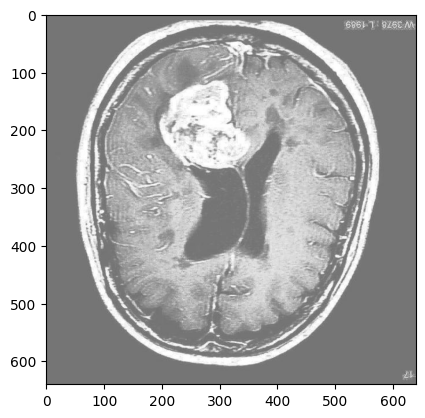

In [51]:
img_path = os.path.join(IMAGES_PATH, "eval", "y47_jpg.rf.d9ccba97b7cdbc7f55f7d3dc98816e73.jpg")
image = cv2.imread(img_path)
image = cv2.cvtColor(image ,cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

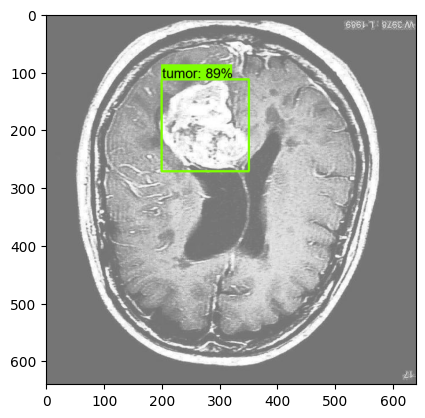

In [52]:
image_np = np.array(image)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect(input_tensor)

num_detections = int(detections.pop("num_detections"))

detections = {key:value[0, :num_detections].numpy() for key, value in detections.items()}
detections["num_detections"] = num_detections
detections["detection_classes"] =  detections["detection_classes"].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_util.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.6,
            agnostic_mode=False)

plt.imshow(image_np_with_detections)
plt.show()